##1> Getting data for FoodVision


In [1]:
import torch
from torch import nn

torch.__version__

'2.8.0+cu126'

In [13]:
from torchvision import datasets, transforms
from pathlib import Path
import torch # Import torch to use torch.float32

# Add fallback for torchvision.transforms.v2
try:
    from torchvision.transforms import v2 as Tv2
except ImportError:
    from torchvision import transforms as Tv2


#setup directory path
from pathlib import Path
data_dir= Path("data")

# Define transform
train_transform=Tv2.Compose([
    Tv2.Resize(256),
    Tv2.CenterCrop(224),
    Tv2.RandomHorizontalFlip(p=0.5),
    Tv2.RandomRotation(degrees=15), # Added RandomRotation
    Tv2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Added ColorJitter
    Tv2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), # Added RandomAffine
    Tv2.RandomPerspective(distortion_scale=0.2, p=0.5), # Added RandomPerspective
    Tv2.Compose([Tv2.ToImage(), Tv2.ToDtype(torch.float32, scale=True)]), # Updated ToTensor()
    Tv2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
    Tv2.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3)) # Added RandomErasing
])

test_transform=Tv2.Compose([
    Tv2.Resize(256),
    Tv2.CenterCrop(224),
    Tv2.Compose([Tv2.ToImage(), Tv2.ToDtype(torch.float32, scale=True)]), # Updated ToTensor()
    Tv2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),

])

# Getting Traing data (~750 images x 101 food classes)
train_data=datasets.Food101(root= data_dir, #path to download data
                            split ="train", # dataset split to get
                            transform=train_transform, # perform data augmentation on training data
                            download=True) # want to download

# Getting Testing data (~250 images x 101 food classes)
test_data=datasets.Food101(root=data_dir,
                           split= "test",
                           transform=test_transform,
                           download=True)

###Visualze an image

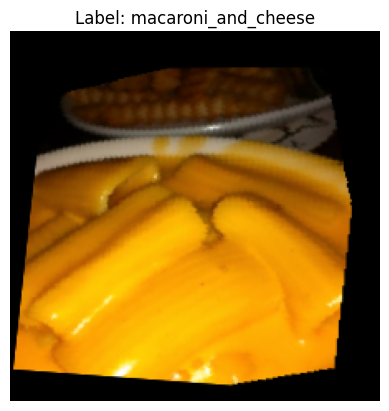

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torchvision.transforms import functional as F # Import functional transforms
from pathlib import Path

# Setup directory path
data_dir = Path("data")

# Load the training data without any transforms
train_data_untransformed = datasets.Food101(
    root=data_dir,
    split="train",
    download=True
)

# Get the class names
class_names = train_data_untransformed.classes

# Pick a random image to display
random_idx = np.random.randint(0, len(train_data_untransformed))
img, label = train_data_untransformed[random_idx]

# Convert PIL Image to PyTorch Tensor and add a batch dimension
img_tensor = F.to_tensor(img).unsqueeze(0)


# Apply the training transform to the image
# Need to add a batch dimension for the transforms
img_augmented = train_transform(img_tensor).squeeze(0)


# Convert the augmented image back to a format suitable for matplotlib
# The augmented image is a PyTorch tensor with shape [C, H, W] and normalized
# Matplotlib expects a NumPy array with shape [H, W, C] and values in [0, 1] or [0, 255]

# Denormalize the image
mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
img_display = img_augmented * std + mean

# Clamp values to [0, 1]
img_display = torch.clamp(img_display, 0, 1)

# Convert to NumPy array and change channel order
img_display = img_display.permute(1, 2, 0).numpy()


# Display the image
plt.imshow(img_display)
plt.title(f"Label: {class_names[label]}")
plt.axis("off")
plt.show()

##2> Create DataLoaders

In [4]:
import torch
import os
from torch.utils.data import DataLoader

# Check the number of available CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of available CPU cores: {num_cpu_cores}")

# Set num_workers to the number of available CPU cores for faster data loading
num_workers = num_cpu_cores

BATCH_SIZE=32

train_dataloader=DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

test_dataloader=DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Number of training batch: {len(train_dataloader)}")
print(f"Number of testing batch: {len(test_dataloader)}")

Number of available CPU cores: 2
Number of training batch: 2368
Number of testing batch: 790


##3> Define Model

Using a pretrained Vision Transformer (ViT-Base/32) model

In [9]:
import torch
from torch import nn
from torchvision import models

# Single canonical device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load a pretrained Vision Transformer (ViT-Base/32) model
model = models.vit_b_32(weights='IMAGENET1K_V1')

# Freeze all layers in base model first
for param in model.parameters():
  param.requires_grad = False

# Replace the classifier head with a new one for 101 classes with LayerNorm, Dropout, and Linear layers
num_ftrs = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.LayerNorm(num_ftrs), # Added LayerNorm
    nn.Dropout(p=0.5), # Increased Dropout layer
    nn.Linear(in_features=num_ftrs, out_features=101)
)

# Initialize the weights of the new classifier head
torch.nn.init.xavier_uniform_(model.heads.head[2].weight)
model.heads.head[2].bias.data.fill_(0.01)

# Unfreeze the last few transformer blocks (e.g., last 2-4)
# The ViT encoder has 12 blocks, indexing from 0 to 11
num_unfreeze_blocks = 4 # Can be adjusted between 2 and 4
for i in range(1, num_unfreeze_blocks + 1):
    for param in model.encoder.layers[-i].parameters(): # Corrected access to layers
        param.requires_grad = True

# Unfreeze the LayerNorm before the head
for param in model.encoder.ln.parameters():
    param.requires_grad = True

# Unfreeze the new classifier head
for param in model.heads.parameters():
  param.requires_grad = True


#move model to device after unfreezing
model.to(device)

Using device: cpu


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##4> Loss Function, Optimizer and scheduler


In [10]:
# # Loss with label smoothing
# loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# # Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# # Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     factor=0.5,        # halve LR
    # patience=3,        # wait 3 epochs of no improvement
#     threshold=1e-3,    # require meaningful improvement
#     cooldown=1,
#     min_lr=1e-6
# )

####4.1 redefine

In [ ]:
import os
import re
from tqdm.auto import tqdm
from google.colab import drive


# Mount Drive
drive.mount("/content/drive", force_remount=False)
MODEL_DIR = "drive/MyDrive/FoodVision_models"
os.makedirs(MODEL_DIR, exist_ok=True)


# Hyperparams & setup (edit if needed)
epochs_total = 20              # final epoch number you want to reach
patience = 5                   # early stopping patience
min_delta = 1e-3               # require at least this improvement to count
initial_lr = 1e-4
weight_decay = 1e-4

# Loss (label smoothing)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer & scheduler will be (re)created below to ensure they exist before resume load
def make_optimizer_and_scheduler(model):
    opt = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt,
        mode="min",
        factor=0.5,
        patience=3,
        threshold=1e-3,
        cooldown=1,
        min_lr=1e-6
    )
    return opt, sch


##5> Training and  Evaluation Loop

In [12]:
# AMP scaler
scaler = torch.amp.GradScaler() if device == "cuda" else None


# Utility: find latest checkpoint file
def find_latest_ckpt(model_dir=MODEL_DIR):
    files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]
    if not files:
        return None
    # Prefer checkpoint files that are saved as dicts with 'epoch' inside (we'll inspect them)
    # We'll still fallback to filename parsing if file is just a state_dict.
    # Choose newest by file mtime (safe fallback)
    files = sorted(files, key=lambda fn: os.path.getmtime(os.path.join(model_dir, fn)), reverse=True)
    return os.path.join(model_dir, files[0])


# Save checkpoint (model + optimizer + scheduler + meta)
def save_checkpoint(model, optimizer, scheduler, epoch, test_acc, model_dir=MODEL_DIR):
    os.makedirs(model_dir, exist_ok=True)
    fname = f"checkpoint_epoch_{epoch:03d}_acc_{test_acc:.4f}.pth"
    path = os.path.join(model_dir, fname)
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "test_acc": test_acc
    }, path)
    print(f"Saved checkpoint: {path}")
    return path

# Delete older checkpoints except keep_path
def delete_previous_models(keep_path, model_dir=MODEL_DIR):
    files = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith(".pth")]
    for f in files:
        if os.path.abspath(f) != os.path.abspath(keep_path):
            try:
                os.remove(f)
                print(f"Deleted: {f}")
            except Exception as e:
                print(f"Could not delete {f}: {e}")


# Load latest checkpoint (robust)
def load_latest_checkpoint(model, optimizer, scheduler, model_dir=MODEL_DIR):
    ckpt_path = find_latest_ckpt(model_dir)
    if ckpt_path is None:
        print("No checkpoint found on Drive. Starting from scratch.")
        return model, optimizer, scheduler, 1, 0.0  # start_epoch (1-based), best_acc

    print(f"Trying to load checkpoint: {ckpt_path}")
    loaded = torch.load(ckpt_path, map_location=device)

    # If checkpoint is a dict with 'model_state_dict' (ours), load everything
    if isinstance(loaded, dict) and "model_state_dict" in loaded:
        model.load_state_dict(loaded["model_state_dict"])
        try:
            optimizer.load_state_dict(loaded["optimizer_state_dict"])
            scheduler.load_state_dict(loaded["scheduler_state_dict"])
            print("Loaded model + optimizer + scheduler from checkpoint.")
        except Exception as e:
            print("Loaded model but could NOT restore optimizer/scheduler state (reinitializing).", e)
        start_epoch = int(loaded.get("epoch", 0)) + 1
        best_acc = float(loaded.get("test_acc", 0.0))
        return model, optimizer, scheduler, start_epoch, best_acc

    # Otherwise it might be a raw state_dict (older format). We'll try to load it while excluding head if needed
    if isinstance(loaded, dict):
        # loaded is likely a state_dict (key->tensor)
        state_dict = loaded
        # Optional: drop keys for 'heads.head' if mismatch
        filtered = {k: v for k, v in state_dict.items() if "heads.head" not in k}
        model_dict = model.state_dict()
        model_dict.update(filtered)
        model.load_state_dict(model_dict)
        print("Loaded raw state_dict (filtered 'heads.head' if present).")
        # Try to parse epoch and acc from filename as fallback:
        m_epoch = re.search(r"epoch[_-]?(\d+)", os.path.basename(ckpt_path))
        m_acc = re.search(r"acc[_-]?([0-9\.]+)", os.path.basename(ckpt_path))
        start_epoch = int(m_epoch.group(1)) + 1 if m_epoch else 1
        best_acc = float(m_acc.group(1).rstrip('.')) if m_acc else 0.0 # Remove trailing period before converting to float
        return model, optimizer, scheduler, start_epoch, best_acc

    # Unexpected file content
    print("Checkpoint found but format not recognized. Starting from scratch.")
    return model, optimizer, scheduler, 1, 0.0


# Train & Test functions (correct accuracy calculation)
def train_step(model, dataloader, optimizer, loss_fn, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in tqdm(dataloader, desc="Train", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.autocast(device_type="cuda" if device == "cuda" else "cpu", enabled=(scaler is not None)):
            logits = model(X)
            loss = loss_fn(logits, y)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Test", leave=False):
            X, y = X.to(device), y.to(device)
            with torch.autocast(device_type="cuda" if device == "cuda" else "cpu", enabled=(scaler is not None)):
                logits = model(X)
                loss = loss_fn(logits, y)

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


# Main resume & training loop
# Ensure optimizer/scheduler exist for loading (we created earlier)
optimizer, scheduler = make_optimizer_and_scheduler(model)

# Try load latest checkpoint from Drive (robust)
model, optimizer, scheduler, start_epoch, best_test_acc = load_latest_checkpoint(model, optimizer, scheduler)
print(f"Resume settings -> start_epoch: {start_epoch}, best_test_acc: {best_test_acc:.4f}")

patience_counter = 0

for epoch in range(start_epoch, epochs_total + 1):
    print(f"\nEpoch {epoch}/{epochs_total}")
    train_loss, train_acc = train_step(model, train_dataloader, optimizer, loss_fn, scaler, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}")

    # Step scheduler (ReduceLROnPlateau expects a metric)
    scheduler.step(test_loss)

    # Print LR(s)
    for i, pg in enumerate(optimizer.param_groups):
        print(f" LR group {i}: {pg['lr']:.6e}")

    # Save best checkpoint (saves optimizer + scheduler too)
    if test_acc > best_test_acc + min_delta:
        best_test_acc = test_acc
        ckpt_path = save_checkpoint(model, optimizer, scheduler, epoch, test_acc)
        # delete previous checkpoints if you want only the current best
        delete_previous_models(ckpt_path)
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

print(f"\nTraining finished. Best test acc: {best_test_acc:.4f}")

###6> Load Saved Model

In [14]:
# Ensure optimizer and scheduler are defined before loading
optimizer, scheduler = make_optimizer_and_scheduler(model)

# Load the latest checkpoint
loaded_model, loaded_optimizer, loaded_scheduler, start_epoch, best_test_acc = load_latest_checkpoint(model, optimizer, scheduler, MODEL_DIR)

print("Model loaded successfully!")
# You can now use the 'loaded_model' for inference or further training

Trying to load checkpoint: drive/MyDrive/FoodVision_models/checkpoint_epoch_018_acc_0.8097.pth
Loaded model + optimizer + scheduler from checkpoint.
Model loaded successfully!


###7> Test Loaded model

In [16]:
# Test the loaded model
print("Testing the loaded model...")
loaded_model.to(device) # Ensure the loaded model is on the correct device
loaded_model.eval() # Explicitly set the model to evaluation mode
test_loss, test_acc = test_step(loaded_model, test_dataloader, loss_fn, device)

print(f"\nLoaded Model Test Loss: {test_loss:.4f} | Loaded Model Test Acc: {test_acc:.4f}")

###8> Visualize Some Results

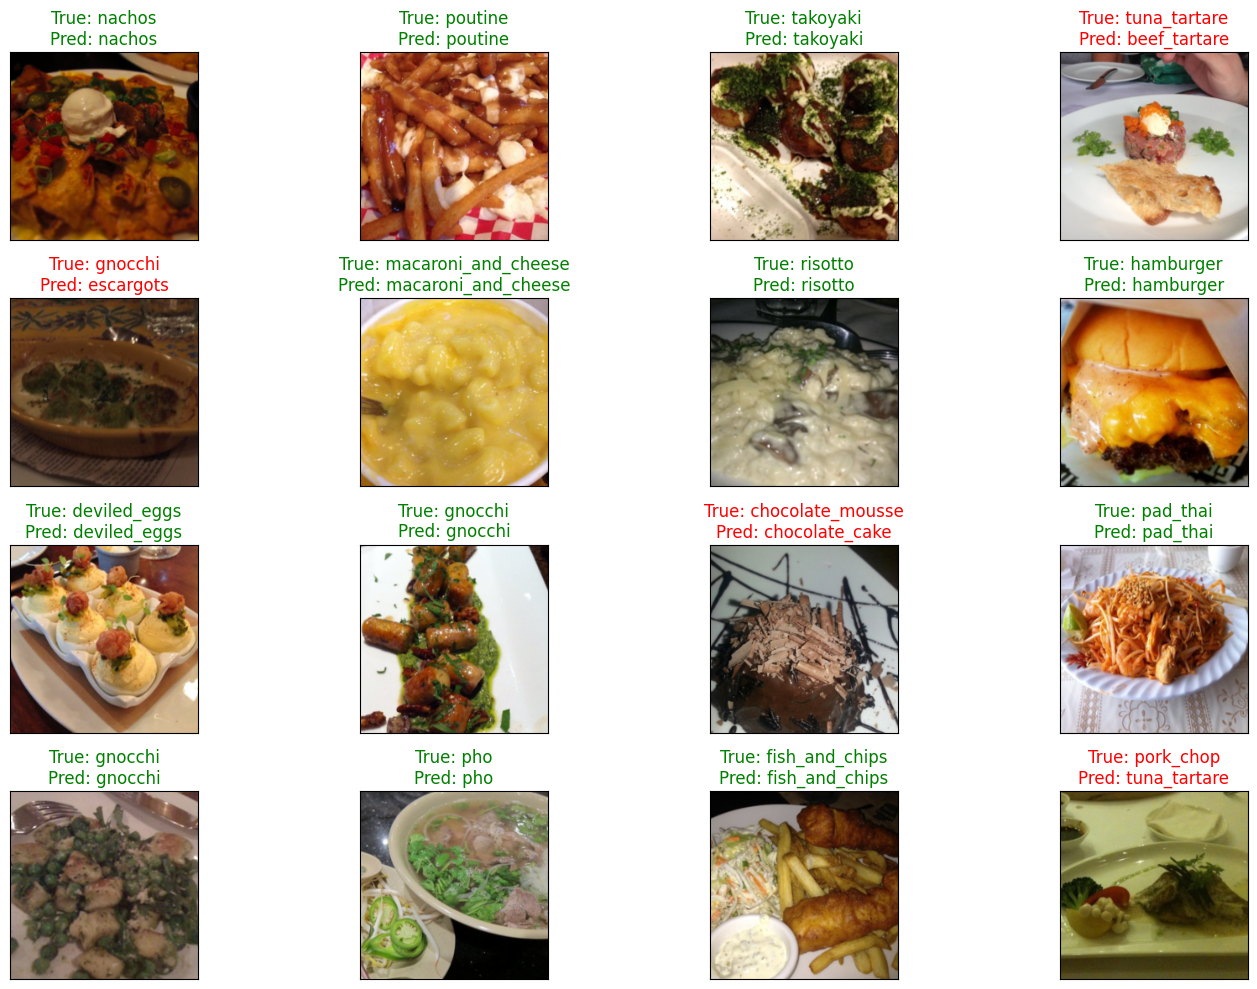

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get class names from the training data (assuming train_data is available)
try:
    class_names = train_data.classes
except NameError:
    print("train_data not found. Cannot display class names.")
    class_names = [str(i) for i in range(101)] # Use index as class name

# Set the number of images to display
num_images_to_display = 16

# Get random indices to sample from the test dataset
random_indices = random.sample(range(len(test_data)), num_images_to_display)

# Plot the images
fig = plt.figure(figsize=(15, 10))
loaded_model.eval() # Ensure the model is in evaluation mode

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        # Get image and label from the dataset
        img, label = test_data[idx]

        # Add a batch dimension and move to device for prediction
        img_tensor = img.unsqueeze(0).to(device)

        # Get prediction
        output = loaded_model(img_tensor)
        _, predicted = torch.max(output, 1)

        # Convert image to numpy for displaying
        # Denormalize and change channel order
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)
        img_display = img_tensor.squeeze(0) * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        img_display = img_display.cpu().permute(1, 2, 0).numpy()


        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plt.imshow(img_display)
        if class_names:
            ax.set_title(f"True: {class_names[label]}\nPred: {class_names[predicted.item()]}",
                         color=("green" if predicted.item() == label else "red"))
        else:
             ax.set_title(f"True: {label}\nPred: {predicted.item()}",
                         color=("green" if predicted.item() == label else "red"))

plt.tight_layout()
plt.show()

###9> Creating a Gradio demo

In [19]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.43.1


####9.1> Creating a function to map our inputs and outputs

In [20]:
from typing import Tuple, Dict
import torch
from timeit import default_timer as timer

# Assuming loaded_model, val_transforms, class_names, and prediction_device are defined in previous cells

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    # Ensure img is a PIL Image before applying transforms
    # Use test_transform for inference
    img = test_transform(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    loaded_model.eval() # Use the loaded_model
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        # Ensure the model is on the correct device for inference
        # Use the defined 'device'
        img = img.to(device) # Move image to the prediction device
        pred_probs = torch.softmax(loaded_model(img), dim=1).squeeze(0) # Use the loaded_model and remove batch dimension

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [22]:
import random
from PIL import Image
from pathlib import Path
import os # Ensure os is imported if not already

# This cell demonstrates how to use the 'predict' function
# to make a prediction on a single image sample from the test dataset.

# Get a random sample from the test dataset
if len(test_data) > 0:
    random_idx = random.randint(0, len(test_data) - 1)
    image, label = test_data[random_idx]

    # Try to get the image path if available in the dataset object
    image_path = "N/A (Sample from dataset)" # Default if path is not easily accessible
    try:
        # This works for datasets inheriting from VisionDataset with _image_files
        image_path = test_data.samples[random_idx][0]
        print(f"[INFO] Predicting on image at path: {image_path}\n")
    except (AttributeError, IndexError):
        print(f"[INFO] Predicting on a random image sample from the test dataset (index {random_idx})\n")


    # Predict on the target image using the 'predict' function
    # The 'predict' function expects a PIL Image as input.
    # If test_data[idx] returns a Tensor, we need to get the untransformed PIL image.
    if isinstance(image, torch.Tensor):
        # Attempt to get the untransformed image from the untransformed dataset
        if 'train_data_untransformed' in globals() and len(train_data_untransformed) > 0:
            random_idx_untransformed = random.randint(0, len(train_data_untransformed) - 1)
            image_untransformed, label_untransformed = train_data_untransformed[random_idx_untransformed]
            print(f"[INFO] Using untransformed image sample from train_data_untransformed (index {random_idx_untransformed}) for prediction demo.\n")
            image = image_untransformed # Use the PIL image

        else:
            print("[WARNING] Could not get untransformed image. Using potentially transformed image from test_data for prediction demo.")


    # Make the prediction using the corrected predict function
    try:
        pred_dict, pred_time = predict(img=image) # Pass the PIL image to predict
        print(f"Prediction label and probability dictionary: \n{pred_dict}")
        print(f"Prediction time: {pred_time} seconds")

    except NameError as e:
        print(f"Error: {e}. Please ensure 'predict', 'loaded_model', 'test_transform', 'class_names', and 'device' are defined.")
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
else:
    print(f"No data found in test_data.")

[INFO] Predicting on a random image sample from the test dataset (index 5104)

[INFO] Using untransformed image sample from train_data_untransformed (index 33230) for prediction demo.

Prediction label and probability dictionary: 
{'apple_pie': 0.00042576275882311165, 'baby_back_ribs': 0.0008021316025406122, 'baklava': 0.001681112335063517, 'beef_carpaccio': 0.004875538870692253, 'beef_tartare': 0.022159036248922348, 'beet_salad': 0.8233583569526672, 'beignets': 0.0006127438391558826, 'bibimbap': 0.0015843365108594298, 'bread_pudding': 0.0007139550289139152, 'breakfast_burrito': 0.0005743470974266529, 'bruschetta': 0.0037836176343262196, 'caesar_salad': 0.0026791333220899105, 'cannoli': 0.0010384294437244534, 'caprese_salad': 0.002931839320808649, 'carrot_cake': 0.0005219689337536693, 'ceviche': 0.008251726627349854, 'cheese_plate': 0.0008464662823826075, 'cheesecake': 0.0004201267729513347, 'chicken_curry': 0.001003453740850091, 'chicken_quesadilla': 0.0008144250605255365, 'chicken_wi

###9.2> Creating a list of example images

In [35]:
# Create a list of example inputs to our Gradio demo
# We will use the manually specified paths provided by the user.

example_list = []
num_examples = 3 # Number of examples to display

# Manually specify paths to a few example images
# These paths are based on the structure: data/food-101/images/<food_name>/<image_name>.jpg
example_image_paths_manual = [
    "/content/data/food-101/images/pizza/1001116.jpg",
    "/content/data/food-101/images/hamburger/100057.jpg",
    "/content/data/food-101/images/ice_cream/1100243.jpg",
]

# Add manual example paths to the example_list, ensuring they exist
for img_path in example_image_paths_manual:
    if os.path.exists(img_path):
        example_list.append([img_path])
    else:
        print(f"Warning: Example image path not found: {img_path}")


if example_list:
    print("Example list created successfully with manually specified paths:")
    print(example_list)
else:
    print("Could not create example list: Manually specified paths not found or list is empty.")
    # example_list remains an empty list

Example list created successfully with manually specified paths:
[['/content/data/food-101/images/pizza/1001116.jpg'], ['/content/data/food-101/images/hamburger/100057.jpg'], ['/content/data/food-101/images/ice_cream/1100243.jpg']]


###9.3> Building a Gradio interface

In [36]:
import gradio as gr

# Create title, description and article strings
title = "Food Vision Model 🍔"
description = "A Vision Transformer (ViT) model trained to classify images of food."
article = "Built using PyTorch and Gradio." # You can update this with a link to your notebook or project if desired.

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://211dda9e35abbbc27e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


##10. Turning our Food 101 Gradio Demo into a deployable app

###10.1> Creating a demos folder to store our Food1O1

In [37]:
import shutil
from pathlib import Path

# Create Food Vision demo path
food_vision_demo_path = Path("demos/food_vision/")

# Remove files that might already exist there and create new directory
if food_vision_demo_path.exists():
    shutil.rmtree(food_vision_demo_path)
# If the file doesn't exist, create it anyway
food_vision_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/food_vision/

###10.2> Creating a folder of example images to use with our Dog Breed Classifier demo

In [38]:
import shutil
from pathlib import Path
import random # Import random
import os # Ensure os is imported if not already

# Assuming food_vision_demo_path is defined in previous cells
# If not, define it here:
# food_vision_demo_path = Path("demos/food_vision/")


# 1. Create an examples directory within the food vision demo path
food_vision_examples_path = food_vision_demo_path / "examples"
food_vision_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect example image paths
# We will try to use the manually specified paths from the previous attempt (cell rX_e70AgT3AK)
# If those paths were not found or example_list is still empty, you might need to adjust them.

# Use the example_list created in cell rX_e70AgT3AK if it's not empty
if example_list:
    example_image_paths_to_copy = [Path(p[0]) for p in example_list] # Convert list of lists of strings to list of Paths
    print(f"Using {len(example_image_paths_to_copy)} example image paths from the generated list.")
else:
    print("Example list is empty or not available. Providing a placeholder for manual paths.")
    # Provide a placeholder for manual paths if the automatic method failed
    example_image_paths_to_copy = []
    # If you want examples, manually add paths to your image files here
    # example_image_paths_to_copy = [
    #     Path("/path/to/your/image1.jpg"),
    #     Path("/path/to/your/image2.png"),
    #     # Add more Path objects here
    # ]


# 3. Copy the selected random images to the examples directory
if example_image_paths_to_copy:
    print(f"Copying {len(example_image_paths_to_copy)} example images to {food_vision_examples_path}:")
    for example_path in example_image_paths_to_copy:
        if example_path.exists():
            destination = food_vision_examples_path / example_path.name
            print(f"[INFO] Copying {example_path} to {destination}")
            shutil.copy2(src=example_path, dst=destination)
        else:
            print(f"[WARNING] Example image path does not exist: {example_path}. Skipping copy.")
else:
    print("No valid example images to copy.")

# Check what's in the examples folder
!ls demos/food_vision/examples/

Using 3 example image paths from the generated list.
Copying 3 example images to demos/food_vision/examples:
[INFO] Copying /content/data/food-101/images/pizza/1001116.jpg to demos/food_vision/examples/1001116.jpg
[INFO] Copying /content/data/food-101/images/hamburger/100057.jpg to demos/food_vision/examples/100057.jpg
[INFO] Copying /content/data/food-101/images/ice_cream/1100243.jpg to demos/food_vision/examples/1100243.jpg
100057.jpg  1001116.jpg  1100243.jpg


In [39]:
import os

# Get example filepaths in a list of lists
# Use the correct path for the examples directory
example_list = [["examples/" + example] for example in os.listdir(food_vision_examples_path)]
example_list

[['examples/100057.jpg'], ['examples/1001116.jpg'], ['examples/1100243.jpg']]

###10.3> Moving our trained Vit_32 model to our Food1O1 demo directory

In [40]:
import shutil
import os # Import os

# Assuming MODEL_DIR (source directory on Drive) and food_vision_demo_path (destination directory) are defined in previous cells

# Find the path to the latest saved model in Google Drive
# This uses the find_latest_ckpt function defined earlier
latest_model_path_on_drive = find_latest_ckpt(MODEL_DIR)

# Create a destination path for our model within the demo directory
# Use the filename from the latest model path
if latest_model_path_on_drive:
    model_filename = os.path.basename(latest_model_path_on_drive)
    model_destination_path_for_demo = food_vision_demo_path / model_filename

    # Try to copy the file from Drive to the demo directory
    if os.path.exists(latest_model_path_on_drive):
        try:
            print(f"[INFO] Attempting to copy {latest_model_path_on_drive} to {model_destination_path_for_demo}")

            # Use shutil.copy2 to copy the file (safer than move across file systems)
            shutil.copy2(src=latest_model_path_on_drive,
                        dst=model_destination_path_for_demo)

            print(f"[INFO] Model copy complete.")

        except Exception as e:
            print(f"[ERROR] An error occurred during model copy: {e}")
    else:
        print(f"[ERROR] Model file not found at source path on Drive: {latest_model_path_on_drive}")

else:
    print("[ERROR] No latest checkpoint found in MODEL_DIR on Google Drive.")


# Check if the model exists in the destination demo directory
if 'model_destination_path_for_demo' in locals():
    print(f"Model exists at {model_destination_path_for_demo}: {model_destination_path_for_demo.exists()}")
else:
    print("Model destination path was not set because no checkpoint was found.")

[INFO] Attempting to copy drive/MyDrive/FoodVision_models/checkpoint_epoch_018_acc_0.8097.pth to demos/food_vision/checkpoint_epoch_018_acc_0.8097.pth
[INFO] Model copy complete.
Model exists at demos/food_vision/checkpoint_epoch_018_acc_0.8097.pth: True


###10.4> Turning our VIT-32 model into a Python script (model.py)

In [42]:
%%writefile demos/food_vision/model.py
import torch
from torch import nn
from torchvision import models

def create_foodvision_model(num_classes: int = 101):
    """Creates a pretrained Vision Transformer (ViT-Base/32) model with a custom classifier head.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 101 (for Food101 dataset).

    Returns:
        model (torch.nn.Module): Vision Transformer model.
    """
    # Load a pretrained Vision Transformer (ViT-Base/32) model
    model = models.vit_b_32(weights='IMAGENET1K_V1')

    # Freeze all layers in base model first
    for param in model.parameters():
      param.requires_grad = False

    # Replace the classifier head with a new one for num_classes
    num_ftrs = model.heads.head.in_features
    model.heads.head = nn.Sequential(
        nn.LayerNorm(num_ftrs),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=num_ftrs, out_features=num_classes)
    )

    # Initialize the weights of the new classifier head
    try:
        torch.nn.init.xavier_uniform_(model.heads.head[2].weight)
        model.heads.head[2].bias.data.fill_(0.01)
    except IndexError:
         print("Warning: Could not initialize weights for the new head. Ensure the head structure is as expected.")


    # Unfreeze the last few transformer blocks (e.g., last 2-4) as done in the notebook
    # The ViT encoder has 12 blocks, indexing from 0 to 11
    num_unfreeze_blocks = 4 # This should match the value used in the notebook if fine-tuned
    for i in range(1, num_unfreeze_blocks + 1):
        for param in model.encoder.layers[-i].parameters():
            param.requires_grad = True

    # Unfreeze the LayerNorm before the head as done in the notebook
    for param in model.encoder.ln.parameters():
        param.requires_grad = True

    # Unfreeze the new classifier head
    for param in model.heads.parameters():
      param.requires_grad = True


    return model

# Example usage (optional, can be removed for just the model definition)
# if __name__ == '__main__':
#     # Create an instance of the model
#     food_model = create_foodvision_model(num_classes=101)
#     print("Food Vision model created:")
#     print(food_model)
#
#     # Example of moving to device (assuming 'device' is defined elsewhere)
#     # food_model.to(device)
#     # print(f"Model moved to {device}")

Overwriting demos/food_vision/model.py


###10.5 Turning our Food101 into a Python script (app.py)

In [43]:
%%writefile demos/food_vision/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch
# import pickle # We'll save class names as a text file
import torchvision.transforms as transforms # Using transforms from torchvision
from PIL import Image
from typing import Tuple, Dict
from timeit import default_timer as timer

# Import the model creation function
from model import create_foodvision_model

# Setup class names - Load from a text file
# Assuming class_names.txt is in the same directory as app.py (will save it later)
class_names_save_path = 'class_names.txt'
class_names = []
try:
    with open(class_names_save_path, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    print(f"Classes list loaded successfully from {class_names_save_path}")
except FileNotFoundError:
    print(f"Error: Classes file not found at {class_names_save_path}. Please ensure the file exists.")
    # Provide a fallback or raise an error if classes are essential
    # Fallback to placeholder names if loading fails
    class_names = [f"Class {i}" for i in range(101)] # Using a default of 101 classes
    print("Using placeholder class names.")
except Exception as e:
    print(f"An error occurred while loading the classes list: {e}")
    # Fallback to placeholder names
    class_names = [f"Class {i}" for i in range(101)] # Using a default of 101 classes
    print("Using placeholder class names.")


### 2. Model and transforms preparation ###

# Create Food Vision model (using the function from model.py)
num_classes = len(class_names) if class_names and class_names[0] != "Class 0" else 101 # Use loaded classes or default
loaded_model = create_foodvision_model(num_classes=num_classes)

# Load saved weights
# Assuming the model file is in the same directory as app.py (copied earlier)
# Find the latest checkpoint file in the current directory (where app.py will be)
def find_latest_ckpt_in_dir(model_dir="."):
    files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]
    if not files:
        return None
    # Choose newest by file mtime
    files = sorted(files, key=lambda fn: os.path.getmtime(os.path.join(model_dir, fn)), reverse=True)
    return os.path.join(model_dir, files[0])

model_save_path = find_latest_ckpt_in_dir(".") # Look for the latest .pth file in the current directory

# Check if the model file exists before loading
if model_save_path and os.path.exists(model_save_path):
    try:
        # Load the state dictionary
        checkpoint = torch.load(model_save_path, map_location=torch.device("cpu"))

        # If the checkpoint is a dict with 'model_state_dict' (our format), load that
        if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
             loaded_model.load_state_dict(checkpoint["model_state_dict"])
             print(f"Model state dictionary loaded successfully from checkpoint dict in {model_save_path}")
        # Otherwise, assume it's just a raw state_dict
        elif isinstance(checkpoint, dict):
             loaded_model.load_state_dict(checkpoint)
             print(f"Model state dictionary loaded successfully from raw state_dict in {model_save_path}")
        else:
             print(f"Warning: Checkpoint format not recognized in {model_save_path}. Attempting to load as raw state_dict.")
             loaded_model.load_state_dict(checkpoint) # Try loading directly


        print(f"Model weights loaded from {model_save_path}")

    except Exception as e:
        print(f"An error occurred while loading the model state dictionary from {model_save_path}: {e}")
        print("Model will use default initialized weights.")
else:
    print(f"Error: Model file not found in the current directory ({os.getcwd()}). Please ensure a .pth model file is present.")
    print("Model will use default initialized weights.")


# Define transforms (using test transforms)
# These should match the test_transform used during training/evaluation
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])


### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Ensure img is a PIL Image before applying transforms
    if not isinstance(img, Image.Image):
        try:
            img = Image.fromarray(img) # Attempt to convert if it's a numpy array or similar
        except:
             print("Warning: Input is not a PIL Image. Attempting prediction anyway.")


    # Transform the target image and add a batch dimension
    # Use the defined test_transform
    img = test_transform(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    loaded_model.eval() # Use the loaded_model
    # Use CPU for inference as map_location was set to cpu
    device = torch.device("cpu")
    loaded_model.to(device)

    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        img = img.to(device) # Move image to the device
        pred_probs = torch.softmax(loaded_model(img), dim=1).squeeze(0) # Use the loaded_model and remove batch dimension

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    if class_names: # Ensure class_names is not empty
        pred_labels_and_probs = {class_names[i]: float(pred_probs[i]) for i in range(len(class_names))}
    else:
        # Fallback if class names weren't loaded
        pred_labels_and_probs = {f"Class {i}": float(pred_probs[i]) for i in range(len(pred_probs))}
        print("Using placeholder class names for predictions.")


    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Food Vision Model 🍔"
description = "A Vision Transformer (ViT) model trained to classify images of food."
article = "Built using PyTorch and Gradio." # You can update this with a link to your notebook or project if desired.

# Create examples list from "examples/" directory
# This assumes the examples directory is a subdirectory of where app.py is located
example_list = [["examples/" + example] for example in os.listdir("examples") if example.endswith(('.jpg', '.jpeg', '.png'))]


# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
if __name__ == "__main__":
    demo.launch()

Writing demos/food_vision/app.py


###10.6 copy the classes.pkl and the model into demos/food_vision

In [45]:
import shutil
import os # Import os

# Assuming food_vision_demo_path is defined
# Assuming class_names is defined (from dataset loading)

# Define destination directory for demo files
demo_dir = food_vision_demo_path

# --- Save Class Names ---
# Save the list of class names to a text file
class_names_save_path_dst = os.path.join(demo_dir, 'class_names.txt')

if 'class_names' in globals() and class_names:
    try:
        with open(class_names_save_path_dst, 'w') as f:
            for class_name in class_names:
                f.write(f"{class_name}\n")
        print(f"Saved class names to {class_names_save_path_dst}")
    except Exception as e:
        print(f"Error saving class names: {e}")
else:
    print("Error: 'class_names' variable not found or is empty. Cannot save class names.")

# Check contents of the demo directory
print("\nContents of demo directory after saving class names:")
!ls {demo_dir}
if (demo_dir / "examples").exists():
    print("\nContents of examples directory:")
    !ls {(demo_dir / "examples")}

Saved class names to demos/food_vision/class_names.txt

Contents of demo directory after saving class names:
app.py				     class_names.txt  model.py
checkpoint_epoch_018_acc_0.8097.pth  examples

Contents of examples directory:
100057.jpg  1001116.jpg  1100243.jpg


###10.7> Req.txt

In [46]:
%%writefile demos/food_vision/requirements.txt
torch
torchvision
gradio
Pillow
tqdm

Writing demos/food_vision/requirements.txt


###Downloading our file in zip

In [47]:
# Change into and then zip the dog_breed_classifier folder but exclude certain files
!cd demos/food_vision && zip -r ../food_vision.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped Dog Breed Classifier app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/food_vision.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 64%)
  adding: checkpoint_epoch_018_acc_0.8097.pth (deflated 7%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/100057.jpg (deflated 0%)
  adding: examples/1001116.jpg (deflated 0%)
  adding: examples/1100243.jpg (deflated 1%)
  adding: model.py (deflated 59%)
  adding: requirements.txt (deflated 3%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>